In [1]:
import numpy as np
import pandas as pd
import os
import json
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, roc_auc_score
from scipy.spatial.distance import pdist, squareform

In [2]:
### load slide features

list_of_files = os.listdir('./slide_classification')

df_slide_features = pd.DataFrame()
for file in list_of_files:
    if not 'slide_features' in file or not file.endswith('.csv'):
        continue
    if 'test' in file:
        continue
    df_feature = pd.read_csv(os.path.join('./slide_classification', file))
    df_feature['slide_label'] = df_feature['slide_id'].apply(lambda x: 1 if 'tumor' in x else 0)
    df_slide_features = pd.concat([df_slide_features, df_feature], ignore_index=True)

df_slide_features = df_slide_features.reset_index(drop=True)
df_slide_features.sort_values(by='slide_id', inplace=True)
print(f"Total slide features: {len(df_slide_features)}")

# find nan records
nan_records = df_slide_features[df_slide_features.isna().any(axis=1)]
display(nan_records)

# remove nan records
df_slide_features = df_slide_features.dropna().reset_index(drop=True)
df_slide_features.to_csv('df_slide_features.csv', index=False)
print(f"Total slide features after removing NaN: {len(df_slide_features)}")

Total slide features: 270


,slide_id,mean_tumor_prob,max_tumor_prob,min_tumor_prob,std_tumor_prob,tumor_tile_fraction,tumor_centroid_x,tumor_centroid_y,tumor_spread_x,tumor_spread_y,entropy_tumor_prob,skew_tumor_prob,kurtosis_tumor_prob,mean_tumor_cluster_dist,mean_neighbor_dist,slide_label
18,normal_019,0.015213,0.608416,0.000951,0.040648,0.000957,321.0,514.0,0.0,0.0,0.067597,8.136779,86.398372,NaN,1.013329,0
138,normal_144,0.002859,0.476457,0.000419,0.009748,0.000000,NaN,NaN,NaN,NaN,0.021451,35.786518,1600.783159,NaN,1.077379,0


Total slide features after removing NaN: 268


In [3]:
### make a stratgified train-test split

def stratified_train_test_split(df, features_to_drop, test_size=0.2, random_state=None):
    normal_slides = df[df['slide_label'] == 0].drop(columns=features_to_drop)
    tumor_slides = df[df['slide_label'] == 1].drop(columns=features_to_drop)
    
    X_normal = normal_slides.drop(columns=['slide_id', 'slide_label'])
    y_normal = normal_slides['slide_label']
    X_tumor = tumor_slides.drop(columns=['slide_id', 'slide_label'])
    y_tumor = tumor_slides['slide_label']
    
    X_normal_train, X_normal_test, y_normal_train, y_normal_test = train_test_split(
        X_normal, y_normal, test_size=test_size, random_state=random_state
    )
    
    X_tumor_train, X_tumor_test, y_tumor_train, y_tumor_test = train_test_split(
        X_tumor, y_tumor, test_size=test_size, random_state=random_state
    )
    
    X_train = pd.concat([X_normal_train, X_tumor_train], ignore_index=True)
    X_test = pd.concat([X_normal_test, X_tumor_test], ignore_index=True)
    y_train = pd.concat([y_normal_train, y_tumor_train], ignore_index=True)
    y_test = pd.concat([y_normal_test, y_tumor_test], ignore_index=True)

    # # Verify the split
    # print(f"Training set: {len(X_train)} slides")
    # print(f"Testing set: {len(X_test)} slides")
    # print(f"Training set (normal): {len(X_normal_train)} slides")
    # print(f"Training set (tumor): {len(X_tumor_train)} slides")
    # print(f"Testing set (normal): {len(X_normal_test)} slides")
    # print(f"Testing set (tumor): {len(X_tumor_test)} slides")
    
    return X_train, X_test, y_train, y_test

In [4]:
### classify slides
random_state = 66
# 66->0.91, 16->0.84, 42->0.82, 99->0.89 for ['tumor_centroid_x', 'tumor_centroid_y']
# 66->0.93, 16->0.87, 42->0.84, 99->0.89 for ['tumor_centroid_x', 'tumor_centroid_y', 'tumor_spread_x', 'tumor_spread_y']
# 66->0.93, 16->0.87, 42->0.80, 99->0.91 for ['tumor_centroid_x', 'tumor_centroid_y', 'tumor_spread_x', 'tumor_spread_y', 'mean_tumor_cluster_dist']

features_to_drop = ['tumor_centroid_x', 'tumor_centroid_y', 'tumor_spread_x', 'tumor_spread_y']
X_train, X_test, y_train, y_test = stratified_train_test_split(
    df_slide_features, features_to_drop, test_size=0.2, random_state=random_state
)

rf_model = RandomForestClassifier(n_estimators=100, criterion='gini', random_state=random_state)
rf_model.fit(X_train, y_train)

# Step 5: Evaluate Model
y_pred = rf_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.93
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        32
           1       0.91      0.91      0.91        23

    accuracy                           0.93        55
   macro avg       0.93      0.93      0.93        55
weighted avg       0.93      0.93      0.93        55



In [5]:
### read in test slide features

# read test gt 
df_test_gt = pd.read_csv('../cam16_test_reference.csv')

list_of_files = os.listdir('./slide_classification')

df_test_features = pd.DataFrame()
for file in list_of_files:
    if not 'slide_features' in file or not file.endswith('.csv'):
        continue
    if not 'test' in file:
        continue
    df_feature = pd.read_csv(os.path.join('./slide_classification', file))

    slide_id = file.replace('.csv', '').replace('slide_features_', '')
    gt = df_test_gt.loc[df_test_gt['image_id']==slide_id, 'type'].values[0]
    
    df_feature['slide_label'] = (1 if gt == 'Tumor' else 0)
    df_test_features = pd.concat([df_test_features, df_feature], ignore_index=True)

df_test_features = df_test_features.reset_index(drop=True)
df_test_features.sort_values(by='slide_id', inplace=True)
print(f"Total test features: {len(df_test_features)}")

# find nan records
nan_records = df_test_features[df_test_features.isna().any(axis=1)]
if len(nan_records) > 0:
    print(f"Found {len(nan_records)} records with NaN values:")
    display(nan_records)

# remove nan records
df_test_features = df_test_features.dropna().reset_index(drop=True)
df_test_features.to_csv('df_test_features.csv', index=False)
print(f"Total slide features after removing NaN: {len(df_test_features)}")

df_test_features.head()

Total test features: 129
Total slide features after removing NaN: 129


,slide_id,mean_tumor_prob,max_tumor_prob,min_tumor_prob,std_tumor_prob,tumor_tile_fraction,tumor_centroid_x,tumor_centroid_y,tumor_spread_x,tumor_spread_y,entropy_tumor_prob,skew_tumor_prob,kurtosis_tumor_prob,mean_tumor_cluster_dist,mean_neighbor_dist,slide_label
0,test_001.csv,0.140170,1.000000,0.000321,0.296231,0.115592,129.908462,139.885769,60.281335,101.332387,0.111338,2.266066,3.561951,129.601693,1.021238,1
1,test_002.csv,0.062597,1.000000,0.000324,0.182417,0.044567,233.208065,589.045161,99.020258,131.938144,0.088402,3.891761,14.958198,198.814701,1.019384,1
2,test_003.csv,0.024899,0.993377,0.000355,0.082995,0.009273,212.330935,572.841727,79.798071,96.638558,0.072178,6.455266,49.140366,151.264291,1.019167,0
3,test_004.csv,0.100998,1.000000,0.000519,0.194386,0.063519,299.617481,217.888946,94.295492,69.137537,0.167522,2.719000,7.120884,142.091907,1.020753,1
4,test_005.csv,0.064067,0.999845,0.000480,0.151735,0.033955,263.164557,713.035443,23.432656,193.209544,0.131178,3.872487,15.945710,203.248203,1.024501,0


In [6]:
df_test_features['slide_label'].value_counts()

0    80
1    49
Name: slide_label, dtype: int64

In [7]:
### Evaluate test slides features
X_test_final = df_test_features.drop(columns=['slide_id', 'slide_label'])
X_test_final = X_test_final.drop(columns=features_to_drop)  # Use the same features as in training

y_test_final = df_test_features['slide_label']

y_pred_final = rf_model.predict(X_test_final)
print(f"Test Accuracy: {accuracy_score(y_test_final, y_pred_final):.2f}")
print(classification_report(y_test_final, y_pred_final))

Test Accuracy: 0.81
              precision    recall  f1-score   support

           0       0.87      0.81      0.84        80
           1       0.72      0.80      0.76        49

    accuracy                           0.81       129
   macro avg       0.79      0.80      0.80       129
weighted avg       0.81      0.81      0.81       129



## Use all train data

In [8]:
### classify slides

# 16, n=50-210, accuracy: 0.81
# 26, n=50-240, accuracy: 0.81
# 36, n=60, accuracy: 0.83
# 46, n=50, accuracy: 0.82
# 56, n=50, accuracy: 0.82
# 66, n=50, accuracy: 0.81

features_to_drop = ['tumor_centroid_x', 'tumor_centroid_y', 'tumor_spread_x', 'tumor_spread_y']
X_train = df_slide_features.drop(columns=['slide_id', 'slide_label'] + features_to_drop)
y_train = df_slide_features['slide_label']

res = []
for random_state in range(6, 100, 10):
    for n_estimators in [50]:
        rf_model = RandomForestClassifier(n_estimators=n_estimators, criterion='gini', random_state=random_state)
        rf_model.fit(X_train, y_train)

        # Step 5: Evaluate Model
        y_pred_final = rf_model.predict(X_test_final)
        y_pred_proba = rf_model.predict_proba(X_test_final)[:, 1]  # Probability for class 1 (tumor)

        # Precision and recall for the positive (tumor) case
        precision_positive = precision_score(y_test_final, y_pred_final, pos_label=1)
        recall_positive = recall_score(y_test_final, y_pred_final, pos_label=1)

        # Precision and recall for the negative (normal) case
        precision_negative = precision_score(y_test_final, y_pred_final, pos_label=0)
        recall_negative = recall_score(y_test_final, y_pred_final, pos_label=0)

        accu = accuracy_score(y_test_final, y_pred_final)
        roc_auc = roc_auc_score(y_test_final, y_pred_proba)  # ROC AUC calculation

        # save results as a dict
        res.append({
            'accuracy': accu,
            'precision_tumor': precision_positive,
            'recall_tumor': recall_positive,
            'precision_normal': precision_negative,
            'recall_normal': recall_negative,
            'roc_auc': roc_auc,
            'predictions': list(zip(df_test_features['slide_id'], [str(x) for x in y_pred_final]))  # Pair slide_id with predictions
        })

        print(f"rs {random_state}, n_estimators {n_estimators}, Accuracy: {accuracy_score(y_test_final, y_pred_final):.2f}, ROC AUC: {roc_auc:.2f}")
        # print(classification_report(y_test_final, y_pred_final))

# calculate mean and std of accuracy, precision, recall
df_res = pd.DataFrame(res)
mean_res = df_res.mean().round(2)
std_res = df_res.std().round(3)
print("Mean Results:")
print(mean_res)
print("Standard Deviation Results:")
print(std_res)        

rs 6, n_estimators 50, Accuracy: 0.81, ROC AUC: 0.85
rs 16, n_estimators 50, Accuracy: 0.81, ROC AUC: 0.84
rs 26, n_estimators 50, Accuracy: 0.81, ROC AUC: 0.83
rs 36, n_estimators 50, Accuracy: 0.81, ROC AUC: 0.84
rs 46, n_estimators 50, Accuracy: 0.82, ROC AUC: 0.86
rs 56, n_estimators 50, Accuracy: 0.82, ROC AUC: 0.85
rs 66, n_estimators 50, Accuracy: 0.81, ROC AUC: 0.84
rs 76, n_estimators 50, Accuracy: 0.80, ROC AUC: 0.85
rs 86, n_estimators 50, Accuracy: 0.79, ROC AUC: 0.84
rs 96, n_estimators 50, Accuracy: 0.81, ROC AUC: 0.84
Mean Results:
accuracy            0.81
precision_tumor     0.74
recall_tumor        0.77
precision_normal    0.86
recall_normal       0.83
roc_auc             0.84
dtype: float64
Standard Deviation Results:
accuracy            0.010
precision_tumor     0.014
recall_tumor        0.026
precision_normal    0.013
recall_normal       0.013
roc_auc             0.009
dtype: float64


/tmp/ipykernel_1650602/588478947.py:51: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean_res = df_res.mean().round(2)
/tmp/ipykernel_1650602/588478947.py:52: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  std_res = df_res.std().round(3)


In [11]:
### sav results to csv
df_res.to_csv('./results_RF_slide_level_classification/slide_classification_results.csv', index=False)

In [12]:
### select best model
best_model = df_res.loc[df_res['accuracy'].idxmax()]
print("Best Model Results:")
print(best_model[['accuracy', 'precision_tumor', 'recall_tumor', 'precision_normal', 'recall_normal', 'roc_auc']])

# make best model predictions into a dataframe
df_best_predictions = pd.DataFrame(best_model['predictions'], columns=['slide_id', 'prediction'])
df_best_predictions['slide_id'] = df_best_predictions['slide_id'].str.replace('.csv', '', regex=False)
df_best_predictions.to_csv('./results_RF_slide_level_classification/slide_predictions_best_accu.csv', index=False)

Best Model Results:
accuracy            0.821705
precision_tumor         0.75
recall_tumor        0.795918
precision_normal     0.87013
recall_normal         0.8375
roc_auc             0.858801
Name: 4, dtype: object


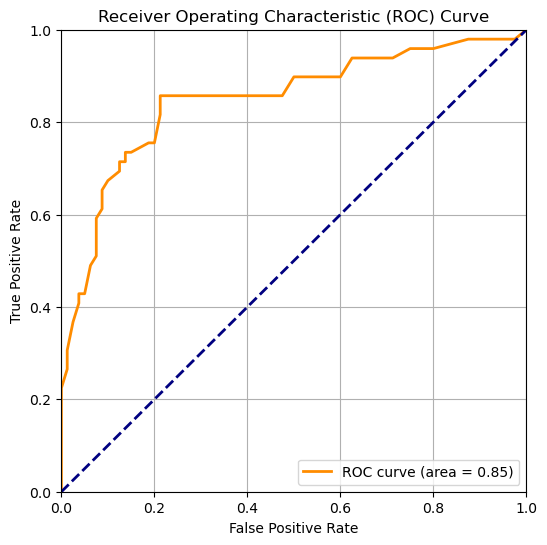

In [13]:
# Plot ROC curve for one random state (first run in res)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Use the first run in res as an example
roc_example = res[df_res['accuracy'].idxmax()]
y_true = y_test_final
# Get the predicted probabilities for class 1 from the first model
rf_model_example = RandomForestClassifier(n_estimators=50, criterion='gini', random_state=6)
rf_model_example.fit(X_train, y_train)
y_score = rf_model_example.predict_proba(X_test_final)[:, 1]
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('./results_RF_slide_level_classification/slide_level_roc_curve.pdf')
plt.show()